In [80]:
import mlflow
import matplotlib
import matplotlib.pyplot as plt

model_dict = {
    "ucc": {
        "experiment_id":"546114710104461663",
        "run_id":"e3e102e875734beb84c3ccb6ca2f46e4"
    },
    "ucc-drn": {
        "experiment_id": "189454739472380536",
        "run_id":"98d0cca708cc4f5ba40314aa134af4cd"
    }
}



runs = mlflow.search_runs(experiment_ids=[x["experiment_id"] for _, x in model_dict.items()], output_format="list")
filtered_runs = [run for run in runs  if run.info.run_id in [x["run_id"] for _, x in model_dict.items()]]

def get_parent_run(run_name, run_id, parent_list):
    if "resume" not in run_name:
        parent_list.append({"run_name": run_name, "run_id": run_id})
        return
    else:
        parent_list.append({"run_name": run_name, "run_id": run_id})
        parent_run_id = run_name.replace("_resume", "")
        parent_run = [run.info.run_name for run in runs if run.info.run_id == parent_run_id ]
        get_parent_run(parent_run[0], parent_run_id, parent_list)


In [81]:
from collections import defaultdict

client = mlflow.MlflowClient()
experiment_id_to_name_map = {x["experiment_id"]: name for name, x in model_dict.items()}
full_metric_dict = defaultdict(dict)
for run in filtered_runs:
    experiment_id = run.info.experiment_id
    run_id = run.info.run_id
    run_name = run.info.run_name
    model_name = experiment_id_to_name_map[experiment_id]
    metric_names = [met for met in run.data.metrics if 'encoder' in met]    
    if "_resume" in run_name:
        p_list = []
        get_parent_run(run_name, run_id, p_list)
        p_list = list(reversed(p_list))
        metric_dict = defaultdict(list)
        for values in p_list:
            run_id = values["run_id"]
            run_name = values["run_name"]
            for metric in metric_names:
                metric_history = client.get_metric_history(run_id, metric)
                metric_dict[metric]+= metric_history
            metric_history = client.get_metric_history(run_id, "train_ucc_loss")
            metric_dict["train_ucc_loss"]+= metric_history
        for metric in metric_names:
            full_metric_dict[metric][model_name] = metric_dict[metric]
        full_metric_dict["train_ucc_loss"][model_name] = metric_dict["train_ucc_loss"]
    else:
        for metric in metric_names:
            metric_history = client.get_metric_history(run_id, metric)
            full_metric_dict[metric][model_name] = metric_history
        metric_history = client.get_metric_history(run_id, "train_ucc_loss")
        full_metric_dict["train_ucc_loss"][model_name] = metric_history
        

In [34]:
full_metric_dict.keys()

dict_keys(['encoder.6.weight', 'encoder.3.blocks.0.conv1.weight', 'encoder.2.blocks.0.conv2.weight', 'encoder.1.blocks.0.conv1.weight', 'encoder.0.weight', 'encoder.3.blocks.0.skip_conv.bias', 'encoder.2.blocks.0.skip_conv.weight', 'encoder.2.blocks.0.conv2.bias', 'encoder.3.blocks.0.conv2.bias', 'encoder.0.bias', 'encoder.1.blocks.0.conv2.bias', 'encoder.2.blocks.0.conv1.weight', 'encoder.1.blocks.0.conv1.bias', 'encoder.1.blocks.0.conv2.weight', 'encoder.2.blocks.0.conv1.bias', 'encoder.3.blocks.0.skip_conv.weight', 'encoder.3.blocks.0.conv1.bias', 'encoder.3.blocks.0.conv2.weight', 'encoder.2.blocks.0.skip_conv.bias', 'train_ucc_loss', 'encoder.1.blocks.0.skip_conv.bias', 'encoder.1.blocks.0.skip_conv.weight', 'encoder.1.weight', 'encoder.2.weight'])

In [82]:
import numpy as np
cutoffs = np.arange(0.7, 1.3, 0.1)[::-1]
value_dict = defaultdict(dict)
for name in list(full_metric_dict.keys()):
    if "encoder" in name:
        for model_name in list(model_dict.keys()):
            previous_cutoff_index = 0
            train_ucc_loss = full_metric_dict["train_ucc_loss"][model_name]
            print(name)
            some_norm = full_metric_dict[name][model_name]
            mean_gradient_list = []
            for i in range(len(cutoffs)):
                current_cutoff = cutoffs[i]
                current_cutoff_index = len([step.step for step in train_ucc_loss if step.value>current_cutoff])
                gradient_norms = [abs(met.value) for met in some_norm[previous_cutoff_index: current_cutoff_index]]
                mean_gradient = np.mean(gradient_norms)
                print(np.min(gradient_norms))
                mean_gradient_list.append(mean_gradient)
                previous_cutoff_index = current_cutoff_index
            value_dict[name][model_name] = mean_gradient_list


encoder.6.weight
2.524398269088124e-06
2.236747786810156e-05
1.2841759371440276e-06
3.2781602499198925e-07
1.9705264264757716e-07
4.968852636011434e-07
1.3764567263763183e-08
encoder.6.weight
5.75107108602424e-08
2.7572136573894568e-08
1.25829870967209e-07
9.296309144701809e-08
3.5467468961769555e-08
3.314035268431326e-08
4.017516319620995e-10
encoder.3.blocks.0.conv1.weight
4.4354795392109736e-08
2.436002830563666e-07
6.654229309788207e-07
4.053193549680145e-07
1.181164407171309e-06
5.986456130813167e-08
5.734364094678313e-10
encoder.3.blocks.0.conv1.weight
1.5875735448478423e-10
4.7440256167874395e-09
1.0786759041536698e-08
1.2440776409050613e-08
2.1034793462604284e-08
6.722681855642065e-10
1.9693402464326937e-10
encoder.2.blocks.0.conv2.weight
3.406716473364213e-07
6.849384703855321e-07
3.609194436648977e-07
8.973810281531769e-07
7.821371355021256e-07
8.876021695414238e-08
8.181410215968299e-09
encoder.2.blocks.0.conv2.weight
1.1395766996713519e-08
7.492295850397568e-08
5.7439642375

In [57]:
cutoffs

array([1.3, 1.2, 1.1, 1. , 0.9, 0.8, 0.7])

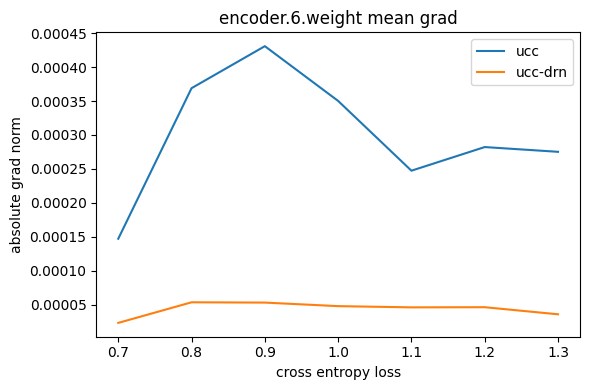

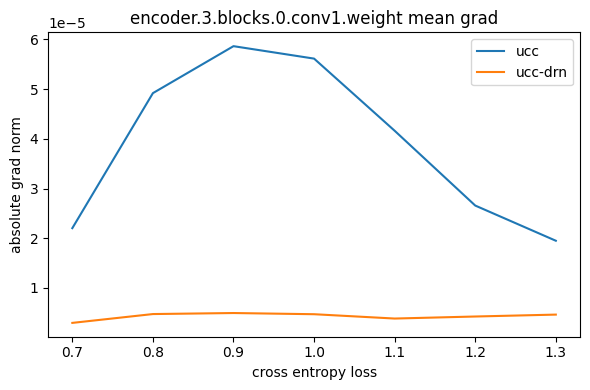

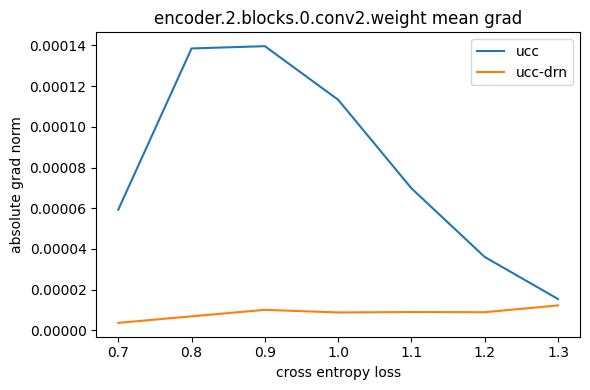

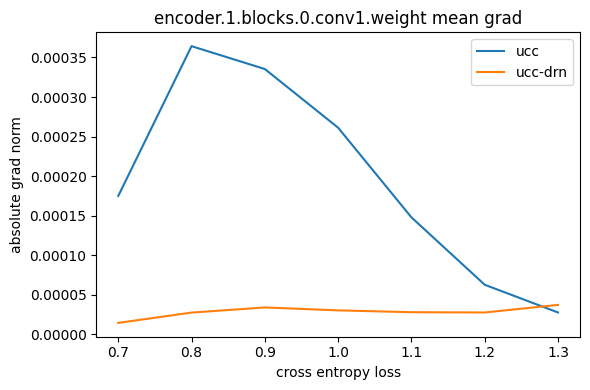

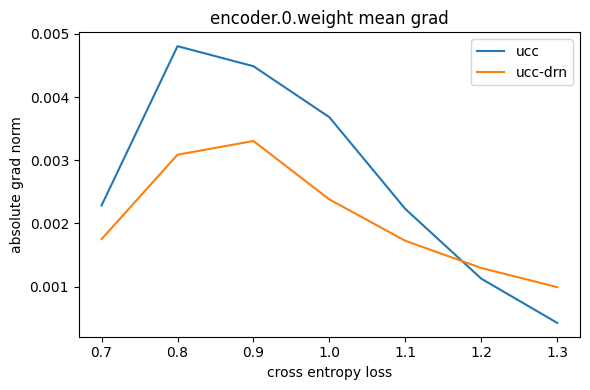

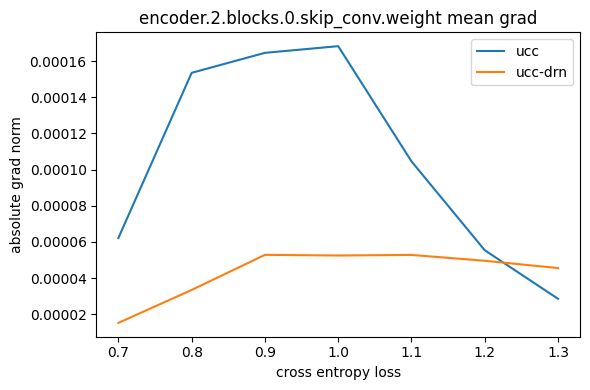

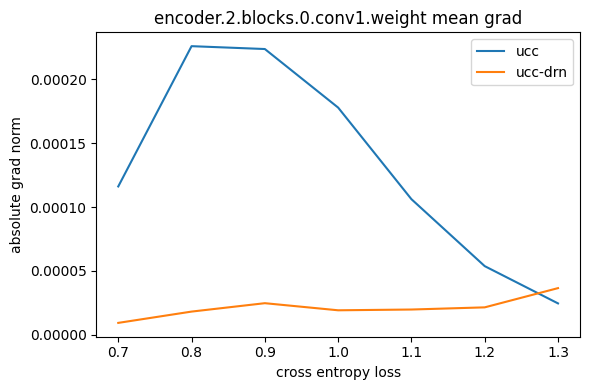

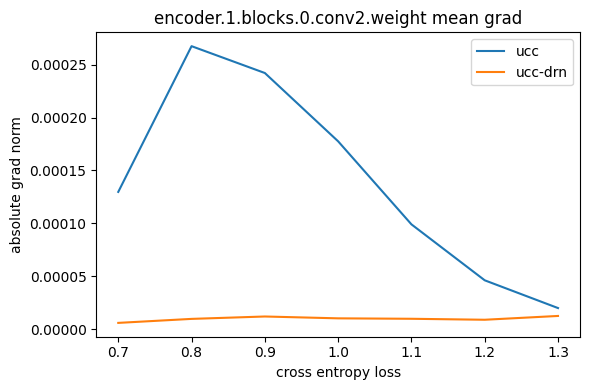

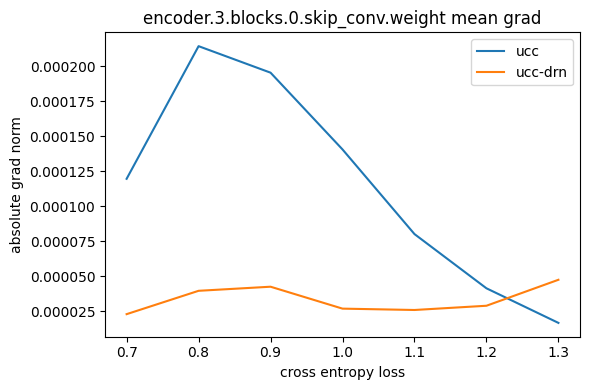

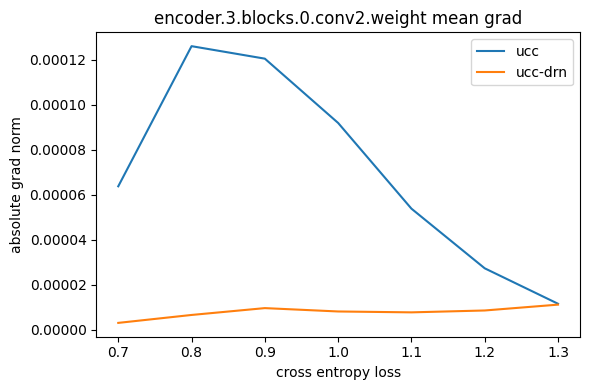

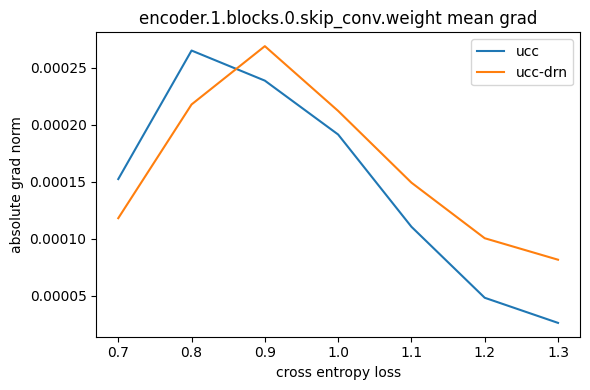

In [84]:
for name in value_dict.keys():
    if "weight" in name:
        fig = plt.figure(figsize=(6,4))
        plt.plot(cutoffs, value_dict[name]["ucc"])
        plt.plot(cutoffs, value_dict[name]["ucc-drn"])
        plt.legend(["ucc", "ucc-drn"])
        plt.title(f'{name} mean grad')
        plt.xlabel("cross entropy loss")
        plt.ylabel("absolute grad norm")
        plt.tight_layout()
        fig.savefig(f"evaluation/{name}.png", bbox_inches='tight')

In [46]:
max_gradient

np.float64(1.2278128327371804e-05)